# 5주차

Auto Encoder 사용하여 DSA 분석

- 2nd AE 실습

(수정된 신용카드 거래 소스올리면, 그걸 해보고 수행한후

응용해서 아래 실습)

1. DSA데이터에서 sitting(normal) jumping(abnormal)만 남김

2. 두개 activity를 섞어서 training / test 

3. training를 다시 training/valid

4. training/valid에서 jumping 데이터를 삭제 ( sitting를 정상데이터로 사용)

5. AE로 valid를 목표로 training을 학습 

6. sitting에 학습된 모델을 가지고, 

AE에 넣어서 Reconstruction error(입력/출력차이)를 구함

7. 적당한 threshold값으로 분류수행

8. accuracy를 구함

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("C:/Project/DeepLearning/Data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.shape

(9120, 272)

In [4]:
df.isnull().values.any()

False

In [5]:
df.columns

Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_std', 'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max',
       'LL_zmag_min', 'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity',
       'people'],
      dtype='object', length=272)

In [6]:
df['activity'].value_counts()

sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: activity, dtype: int64

### 1.DSA데이터에서 sitting(normal), jumping(abnormal)만 남기기

In [7]:
df_filtered = df[df['activity'].isin(['sitting', 'jumping'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting


In [17]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,1


In [18]:
df_filtered['activity'].value_counts()

1    480
0    480
Name: activity, dtype: int64

sitting = Normal = 1

jumping = Abnormal = 0

In [19]:
LABELS = ["Normal", "Abnormal"]

In [20]:
normal = df_filtered[df_filtered.activity == 1]
abnormal = df_filtered[df_filtered.activity == 0]
normal.shape

(480, 271)

In [21]:
abnormal.shape

(480, 271)

In [22]:
X_train, X_test = train_test_split(df_filtered, test_size=0.2, random_state=12)
X_train = X_train[X_train.activity == 1]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train

array([[ 6.82727920e+00,  7.04710000e+00,  6.74950000e+00, ...,
         6.14900090e-07,  7.84155654e-04,  2.01303493e-02],
       [ 9.26134240e+00,  9.36300000e+00,  9.13990000e+00, ...,
         4.79095897e-07,  6.92167535e-04, -3.39685410e-01],
       [ 9.63063520e+00,  9.71860000e+00,  9.52500000e+00, ...,
         7.72694516e-07,  8.79030441e-04, -3.23493433e-01],
       ...,
       [ 6.87320640e+00,  7.08540000e+00,  6.74960000e+00, ...,
         7.07429677e-07,  8.41088389e-04, -9.70400942e-02],
       [ 6.90843120e+00,  6.96630000e+00,  6.84680000e+00, ...,
         4.44962297e-07,  6.67054943e-04, -1.59079611e-01],
       [ 8.92051840e+00,  9.06070000e+00,  8.77770000e+00, ...,
         4.12922581e-07,  6.42590523e-04,  1.43819966e-02]])

In [24]:
X_train.shape

(394, 270)

### 4. AE로 sitting 정보만 가진 Train 데이터로 모델 학습

In [33]:
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 270)]             0         
                                                                 
 dense_12 (Dense)            (None, 14)                3794      
                                                                 
 dense_13 (Dense)            (None, 7)                 105       
                                                                 
 dense_14 (Dense)            (None, 7)                 56        
                                                                 
 dense_15 (Dense)            (None, 270)               2160      
                                                                 
Total params: 6115 (23.89 KB)
Trainable params: 6115 (23.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# 3. 모델 학습
# 훈련데이터의 0.25 을 validation data로 사용
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split = 0.25)

Epoch 1/50
2/2 [==============================] - 1s 116ms/step - loss: 5.5705 - val_loss: 5.5412
Epoch 2/50
2/2 [==============================] - 0s 20ms/step - loss: 5.5611 - val_loss: 5.5350
Epoch 3/50
2/2 [==============================] - 0s 21ms/step - loss: 5.5550 - val_loss: 5.5312
Epoch 4/50
2/2 [==============================] - 0s 19ms/step - loss: 5.5512 - val_loss: 5.5290
Epoch 5/50
2/2 [==============================] - 0s 20ms/step - loss: 5.5490 - val_loss: 5.5274
Epoch 6/50
2/2 [==============================] - 0s 20ms/step - loss: 5.5474 - val_loss: 5.5258
Epoch 7/50
2/2 [==============================] - 0s 20ms/step - loss: 5.5458 - val_loss: 5.5243
Epoch 8/50
2/2 [==============================] - 0s 19ms/step - loss: 5.5442 - val_loss: 5.5225
Epoch 9/50
2/2 [==============================] - 0s 21ms/step - loss: 5.5423 - val_loss: 5.5200
Epoch 10/50
2/2 [==============================] - 0s 19ms/step - loss: 5.5398 - val_loss: 5.5167
Epoch 11/50
2/2 [===========

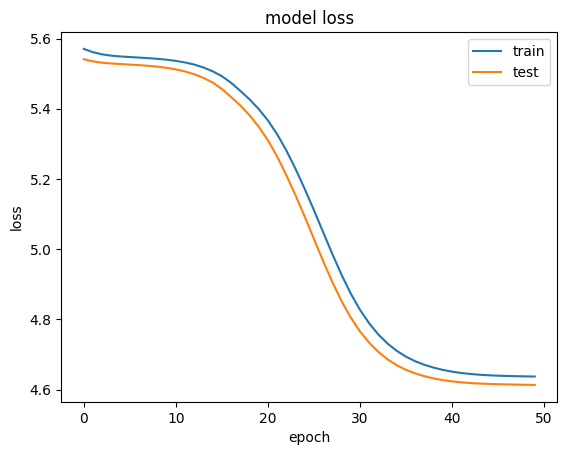

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [36]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

6/6 [==============================] - 0s 1000us/step


,reconstruction_error,true_class
count,192.000000,192.000000
mean,302.040870,0.447917
std,387.568805,0.498580
min,4.393702,0.000000
25%,4.574646,0.000000
50%,87.122526,0.000000
75%,612.196467,1.000000
max,2137.739255,1.000000


In [37]:
error_df.head()

,reconstruction_error,true_class
8426,805.449864,0
201,4.545417,1
8625,634.005706,0
8175,976.270845,0
423,6.587804,1


label이 1인 feature만 학습했기 때문에, Test 데이터에서 0에 대한 reconstruction_error값이 매우 높게 나오고 있다.

In [38]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정

threshold = 15

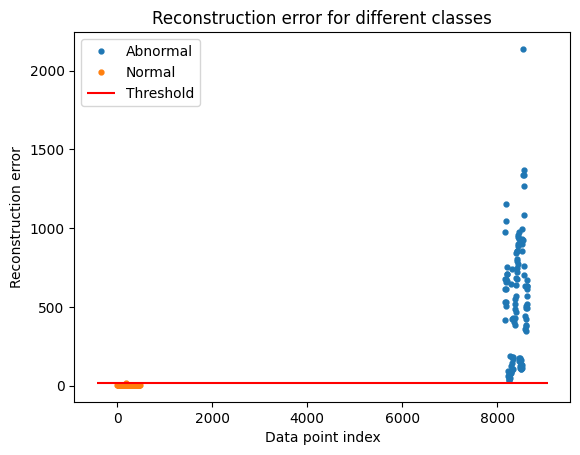

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

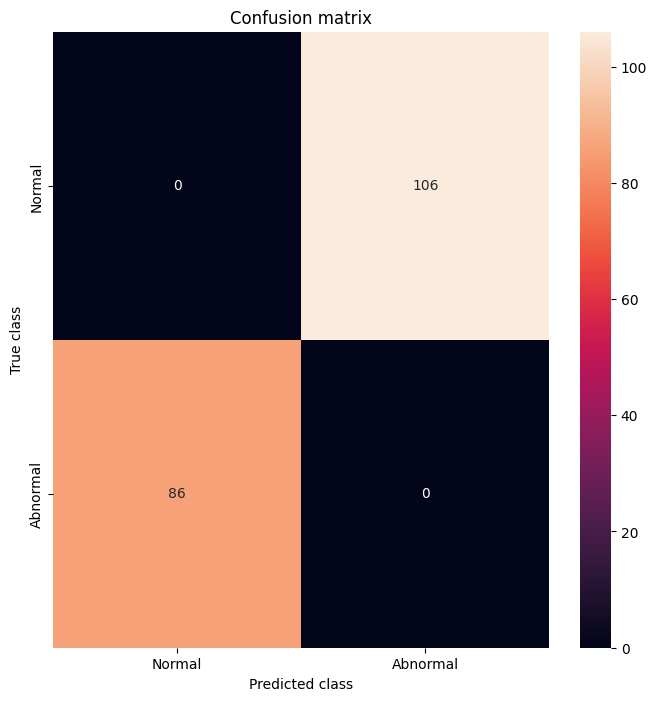

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     106.0
           1       0.00      0.00      0.00      86.0

    accuracy                           0.00     192.0
   macro avg       0.00      0.00      0.00     192.0
weighted avg       0.00      0.00      0.00     192.0



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))